In [1]:
import torch
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, LogLocator
from spectre.spectrum_general import sim_solution
from spectre.spectrum_general import element_wise
from spectre.spectrum_general import recursive_g
from spectre.spectrum_general import recursive_g_torch
from scipy.stats import linregress
from spectre.model import HR
import numpy as np
import sympy as sp


plt.rc("text", usetex=True)
plt.rc("font", family="serif")
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device = torch.device("cpu")

fileloc = r"../figures/recursive_g/"

In [2]:
# Define the system size
n = 1

# Define the diagonal rate matrix Y
Y = torch.diag(torch.rand(n))

# Define the connectivity matrix G
G = torch.randn(n, n)
G = 0.9 * G / torch.max(torch.abs(torch.linalg.eigvals(G))) # redefining the spectral radius of G to be a 0.9

In [3]:
recursive_sol = recursive_g(G=G, Y=Y)
# S_recursive = recursive_g_torch(G=G, Y=Y)

S = recursive_sol.S

In [4]:
S_brute = []
for i in range(2*n+1):
    temp = 0
    for j in range(i+1):
        temp += torch.linalg.matrix_power(G, i-j) @ Y @ torch.linalg.matrix_power(G.T, j)
    S_brute.append(temp)

In [5]:
# # ## check if the two solutions are the same
# for i in range(2*n+1):
#     print(torch.allclose(torch.from_numpy(np.array(S[i]).astype(np.float32)), S_brute[i], atol=1e-5))

### For a ring network

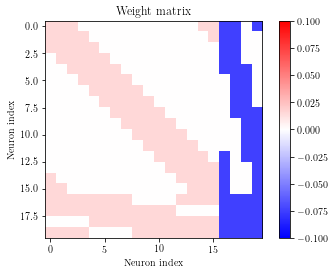

In [6]:
def create_neural_network(N, a, connection_radius_exc, connection_radius_inh, connection_radius_EI, connection_radius_IE):
    N_exc = int(a * N)
    N_inh = N - N_exc
    
    # Create weight matrix
    W = np.zeros((N, N))
    
    # Create connections for excitatory neurons (including self-connections)
    for i in range(N_exc):
        for j in range(N_exc):
            # Calculate distance on the excitatory ring
            dist = min((i - j) % N_exc, (j - i) % N_exc)
            if dist <= connection_radius_exc:
                W[i, j] = 0.015
    
    # Create connections for inhibitory neurons (including self-connections)
    for i in range(N_exc, N):
        for j in range(N_exc, N):
            # Calculate distance on the inhibitory ring
            dist = min((i - j) % N_inh, (j - i) % N_inh)
            if dist <= connection_radius_inh:
                W[i, j] = -0.075
    
    # Create connections from I to E neurons
    for i in range(N_exc):
        for j in range(N_exc, N):
            # Map inhibitory neuron index to the excitatory ring scale
            j_mapped = int((j - N_exc) * (a / (1 - a)))
            
            # Calculate distance between inhibitory and excitatory neurons
            dist_inh_to_exc = min((i - j_mapped) % N_exc, (j_mapped - i) % N_exc)
            
            # Scale the connection radius for inhibitory neurons
            # scaled_radius_inh = int(connection_radius_inh * (a / (1 - a)))
            scaled_radius_inh = connection_radius_EI
            
            if dist_inh_to_exc <= scaled_radius_inh:
                W[i, j] = -0.075

    # Create connections from E to I neurons
    for i in range(N_exc, N):
        for j in range(N_exc):
            # Map excitatory neuron index to the inhibitory ring scale
            j_mapped = int(j * ((1 - a) / a) + N_exc)
            
            # Calculate distance between excitatory and inhibitory neurons
            dist_exc_to_inh = min((i - j_mapped) % N_inh, (j_mapped - i) % N_inh)
            
            # Scale the connection radius for excitatory neurons
            # scaled_radius_exc = int(connection_radius_exc * ((1 - a) / a))
            scaled_radius_exc = connection_radius_IE
            
            if dist_exc_to_inh <= scaled_radius_exc:
                W[i, j] = 0.015
    
    return W

# Example usage
N = 20  # Total number of neurons
a = 0.8   # Fraction of excitatory neurons
connection_radius_exc = 0.1 * N  # Number of neighbors to connect in each direction for excitatory neurons
connection_radius_inh = 0.1 * N   # Number of neighbors to connect in each direction for inhibitory neurons
connection_radius_EI = 0.2 * N   # Number of neighbors to connect between excitatory and inhibitory neurons
connection_radius_IE = 0.05 * N   # Number of neighbors to connect between excitatory and inhibitory neurons

W = create_neural_network(N, a, connection_radius_exc, connection_radius_inh, connection_radius_EI, connection_radius_IE)

# Plot the weight matrix
plt.figure()
plt.imshow(W, cmap='bwr', vmin=-0.1, vmax=0.1)
plt.colorbar()
plt.title('Weight matrix')
plt.xlabel('Neuron index')
plt.ylabel('Neuron index')
plt.show()

In [7]:
# find the percent of nonzero entries in the weight matrix
percent_nonzero = np.count_nonzero(W) / (N * N)
print(percent_nonzero)

0.45


In [8]:
# define the external drive
Y = 10 * torch.eye(N)

# define the connectivity matrix
G = torch.from_numpy(W).float()

In [9]:
n_max = 2 * N + 1
# n_max = 20

In [10]:
# recursive_sol = recursive_g(G=G, Y=Y, n_max=n_max)
# S = recursive_sol.S

# # for sympy
# c = [0] * n_max

# for idx, mat in enumerate(S):
#     c[idx] = float(sum(mat).evalf()) / (N * N)
#     # c[idx] = c[idx] / (idx + 1)

# # convert c to numpy array
# c = np.array(c)

In [11]:
# for torch
recursive_sol_torch = recursive_g_torch(G=G, Y=Y, n_max=n_max)
S_torch = recursive_sol_torch.S

c_torch = [0] * n_max

for idx, mat in enumerate(S_torch):
    c_torch[idx] = torch.sum(mat).item() / (N * N)
    # c_torch[idx] = c_torch[idx] / (idx + 1)

# convert c to numpy array
c_torch = np.array(c_torch)

In [12]:
# brute force
c_brute = [0] * n_max

for i in range(n_max):
    mat = 0
    for j in range(i+1):
        mat += torch.linalg.matrix_power(G, i-j) @ Y @ torch.linalg.matrix_power(G.T, j)
    c_brute[i] = torch.sum(mat).item() / (N * N)
    # c_brute[i] = c_brute[i] / (i + 1)

c_brute = np.array(c_brute)

In [13]:
# fit a line to the data
x = np.arange(n_max)

# Fit line through x and log(y)
log_c_torch = np.log(abs(c_torch))

slope_torch, intercept_torch, _, _, _ = linregress(x[3:], log_c_torch[3:])
fit_torch = np.exp(intercept_torch + slope_torch * x)
print(f"torch slope: {slope_torch}")
print(f"e_effective: {np.exp(slope_torch)}")

torch slope: -1.6383977647775487
e_effective: 0.19429109306881612


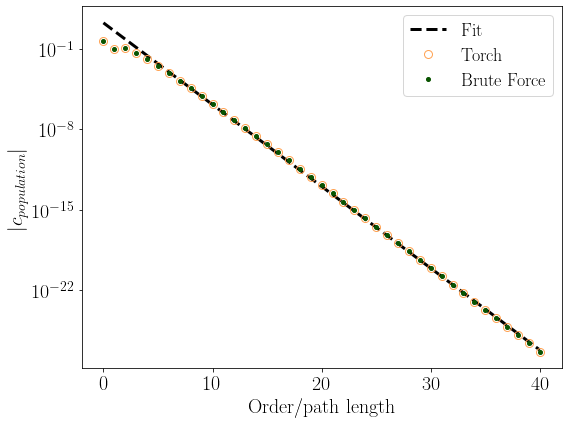

In [14]:
color_recursive = "#FFA353"
color_brute_force = "#095400"

plt.figure(figsize=(8, 6))
# x = np.exp(np.arange(n_max))

plt.plot(x, fit_torch, '--', linewidth=3, color='k', label='Fit')
# plt.plot(x, abs(c), 'o-', color='k', linewidth=4, label='Sympy')
plt.plot(x, abs(c_torch), 'o', color=color_recursive,  markersize=8, markerfacecolor='none', label='Torch')
plt.plot(x, abs(c_brute), 'o', color=color_brute_force, markersize=4,label='Brute Force')


# plt.xscale('log')
plt.yscale('log')
plt.xlabel('Order/path length', fontsize=20)
plt.ylabel('$|c_{population}|$', fontsize=20)
plt.legend(fontsize=18)

# Adjusting tick parameters
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Customizing the number of ticks for logarithmic scale
# display only 5 ticks on x axis
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=5))
plt.gca().yaxis.set_major_locator(LogLocator(base=10.0, numticks=5))
plt.tight_layout()

plt.show()

In [15]:
c_ring_brute = abs(c_brute)
c_ring_torch = abs(c_torch)
c_ring_fit = abs(fit_torch)

### For a random network

In [16]:
def create_neural_network(N, excitatory_percent, p, g_e, g_i):
    num_excitatory = int(N * excitatory_percent)
    num_inhibitory = N - num_excitatory
    
    G = torch.zeros((N, N))
        
    # Create a list of neuron types (1 for excitatory, -1 for inhibitory)
    neuron_types = torch.cat((torch.ones(num_excitatory), -torch.ones(num_inhibitory)))
    
    # Shuffle the neuron types
    neuron_types = neuron_types[torch.randperm(N)]
    
    # Create random connections with the specified probability
    for i in range(N):
        for j in range(N):
            if np.random.rand() < p:
                if neuron_types[j] == 1:
                    G[i, j] = g_e
                else:
                    G[i, j] = g_i
    
    return G, neuron_types


# N = 20  # Total number of neurons
excitatory_percent = 0.8  # 80% excitatory neurons
p = percent_nonzero  # Probability of connection
g_e = 0.015  # Excitatory synaptic strength
g_i = -0.075  # Inhibitory synaptic strength

# define the external drive
Y = 10 * torch.eye(N)

# Find the integrated kernel matrix
G, neuron_types = create_neural_network(N, excitatory_percent, p, g_e, g_i)

# print(G)
print(neuron_types)
print(torch.count_nonzero(G) / (N**2))
print(torch.max(torch.abs(torch.linalg.eigvals(G))))

tensor([-1.,  1.,  1., -1.,  1.,  1., -1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,
         1.,  1.,  1.,  1.,  1.,  1.])
tensor(0.4700)
tensor(0.0963)


In [17]:
# print(G)

In [18]:
n_max = 2 * N + 1
# n_max = 20

In [19]:
# # for sympy
# recursive_sol = recursive_g(G=G, Y=Y, n_max=n_max)
# S = recursive_sol.S

# c = [0] * n_max

# for idx, mat in enumerate(S):
#     c[idx] = float(sum(mat).evalf()) / (N * N)
#     # c[idx] = c[idx] / (idx + 1)

# # convert c to numpy array
# c = np.array(c)

In [20]:
# for torch
recursive_sol_torch = recursive_g_torch(G=G, Y=Y, n_max=n_max)
S_torch = recursive_sol_torch.S

c_torch = [0] * n_max

for idx, mat in enumerate(S_torch):
    c_torch[idx] = torch.sum(mat).item() / (N * N)
    # c_torch[idx] = c_torch[idx] / (idx + 1)

# convert c to numpy array
c_torch = np.array(c_torch)

In [21]:
# brute force
c_brute = [0] * n_max

for i in range(n_max):
    mat = 0
    for j in range(i+1):
        mat += torch.linalg.matrix_power(G, i-j) @ Y @ torch.linalg.matrix_power(G.T, j)
    c_brute[i] = torch.sum(mat).item() / (N * N)
    # c_brute[i] = c_brute[i] / (i + 1)

c_brute = np.array(c_brute)

In [22]:
# fit a line to the data
x = np.arange(n_max)

# Fit line through x and log(y)
log_c_torch = np.log(abs(c_torch))

slope_torch, intercept_torch, _, _, _ = linregress(x[2:], log_c_torch[2:])
fit_torch = np.exp(intercept_torch + slope_torch * x)
print(f"torch slope: {slope_torch}")
print(f"e_effective: {np.exp(slope_torch)}")

torch slope: -2.2697361011355226
e_effective: 0.10333944764789225


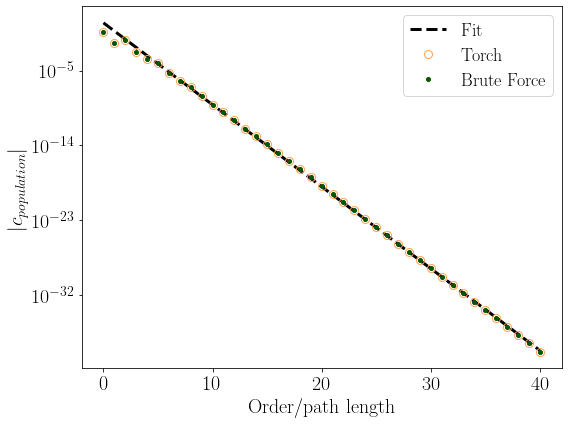

In [23]:
color_recursive = "#FFA353"
color_brute_force = "#095400"

plt.figure(figsize=(8, 6))
# x = np.exp(np.arange(n_max))

plt.plot(x, fit_torch, '--', linewidth=3, color='k', label='Fit')
# plt.plot(x, abs(c), 'o-', color='k', linewidth=4, label='Sympy')
plt.plot(x, abs(c_torch), 'o', color=color_recursive,  markersize=8, markerfacecolor='none', label='Torch')
plt.plot(x, abs(c_brute), 'o', color=color_brute_force, markersize=4,label='Brute Force')


# plt.xscale('log')
plt.yscale('log')
plt.xlabel('Order/path length', fontsize=20)
plt.ylabel('$|c_{population}|$', fontsize=20)
plt.legend(fontsize=18)

# Adjusting tick parameters
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Customizing the number of ticks for logarithmic scale
# display only 5 ticks on x axis
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=5))
plt.gca().yaxis.set_major_locator(LogLocator(base=10.0, numticks=5))
plt.tight_layout()

plt.show()

In [24]:
c_random_brute = abs(c_brute)
c_random_torch = abs(c_torch)
c_random_fit = abs(fit_torch)

### Combining the two plots

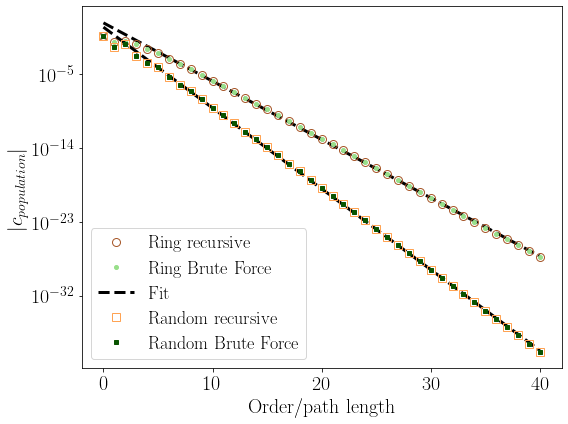

In [36]:
color_recursive = "#FFA353"
color_brute_force = "#095400"

plt.figure(figsize=(8, 6))
# x = np.exp(np.arange(n_max))

# plot the ring network
plt.plot(x, c_ring_fit, '--', linewidth=3, color='k', label=None)
plt.plot(x, c_ring_torch, 'o', color='#a65628',  markersize=8, markerfacecolor='none', label='Ring recursive')
plt.plot(x, c_ring_brute, 'o', color='#98df8a', markersize=4, label='Ring Brute Force')

# plot the random network
plt.plot(x, c_random_fit, '--', linewidth=3, color='k', label='Fit')
# plt.plot(x, abs(c), 'o-', color='k', linewidth=4, label='Sympy')
plt.plot(x, c_random_torch, 's', color=color_recursive,  markersize=8, markerfacecolor='none', label='Random recursive')
plt.plot(x, c_random_brute, 's', color=color_brute_force, markersize=4,label='Random Brute Force')


# plt.xscale('log')
plt.yscale('log')
plt.xlabel('Order/path length', fontsize=20)
plt.ylabel('$|c_{population}|$', fontsize=20)
plt.legend(fontsize=18)

# Adjusting tick parameters
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

# Customizing the number of ticks for logarithmic scale
# display only 5 ticks on x axis
plt.gca().xaxis.set_major_locator(MaxNLocator(nbins=5))
plt.gca().yaxis.set_major_locator(LogLocator(base=10.0, numticks=5))
# change location of legent to bottom left
plt.legend(loc='lower left', fontsize=18)
plt.tight_layout()
# save the figure
plt.savefig(fileloc + "plot.svg", format="svg", dpi=1200)

plt.show()